<a href="https://colab.research.google.com/github/HemantTiwariGitHub/GestureRecognition/blob/master/GestureRecognitionFromVideo_3DConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition


In [157]:
import numpy as np
import os
from imageio import imread
import cv2

import datetime
import os
import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)

from keras import backend as K
import tensorflow as tf


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
batch_size = 1000

In [25]:
def plot_image(images, captions=None, cmap=None, figWidth=15 ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(figWidth)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [158]:
#Explore Image
train_path = '/content/drive/My Drive/Project_data/train'
VideoIndex = 0;
path =  train_doc[VideoIndex].split(';')[0]
print ("Path:", path)
completePath =  train_path+"/"+path
sequenceFiles =  os.listdir(completePath)
print(sequenceFiles)
imageList=[]
for imgFile in sequenceFiles:
  image = cv2.imread(completePath+'/'+imgFile)
  imageList.append(image)
  




Path: WIN_20180926_16_54_08_Pro_Right_Swipe_new
['WIN_20180926_16_54_08_Pro_00008.png', 'WIN_20180926_16_54_08_Pro_00012.png', 'WIN_20180926_16_54_08_Pro_00018.png', 'WIN_20180926_16_54_08_Pro_00028.png', 'WIN_20180926_16_54_08_Pro_00022.png', 'WIN_20180926_16_54_08_Pro_00026.png', 'WIN_20180926_16_54_08_Pro_00006.png', 'WIN_20180926_16_54_08_Pro_00014.png', 'WIN_20180926_16_54_08_Pro_00030.png', 'WIN_20180926_16_54_08_Pro_00032.png', 'WIN_20180926_16_54_08_Pro_00016.png', 'WIN_20180926_16_54_08_Pro_00020.png', 'WIN_20180926_16_54_08_Pro_00024.png', 'WIN_20180926_16_54_08_Pro_00010.png', 'WIN_20180926_16_54_08_Pro_00062.png', 'WIN_20180926_16_54_08_Pro_00060.png', 'WIN_20180926_16_54_08_Pro_00048.png', 'WIN_20180926_16_54_08_Pro_00054.png', 'WIN_20180926_16_54_08_Pro_00052.png', 'WIN_20180926_16_54_08_Pro_00038.png', 'WIN_20180926_16_54_08_Pro_00044.png', 'WIN_20180926_16_54_08_Pro_00064.png', 'WIN_20180926_16_54_08_Pro_00056.png', 'WIN_20180926_16_54_08_Pro_00036.png', 'WIN_20180926_1

In [159]:
def normalizeImage(imageInput, type):
  if (type=="norm"):
    print("5%",np.percentile(imageInput,5))
    print("95%",np.percentile(imageInput,95))
    return ((imageInput - np.percentile(imageInput,5))/(np.percentile(imageInput,95)-np.percentile(imageInput,5)))
  elif (type =="std"):
    return  ((imageInput - imageInput.mean())/(imageInput.std()+1e-8))

In [150]:
a=np.array([[[0,1,2],[3,4,5],[6,7,8]]])
print(np.resize(a,(2,2)))

[[0 1]
 [2 3]]


[[[ 48  63  92]
  [ 48  62  94]
  [ 52  66 100]
  ...
  [ 35  35  28]
  [ 32  32  25]
  [ 31  31  24]]

 [[ 50  64  96]
  [ 51  65  99]
  [ 53  66 103]
  ...
  [ 86  86  79]
  [ 65  65  58]
  [ 53  53  46]]

 [[ 46  56  94]
  [ 49  59  96]
  [ 50  59  99]
  ...
  [108 108 101]
  [101 101  94]
  [ 96  96  90]]

 ...

 [[ 39  41  57]
  [ 37  39  54]
  [108 108 121]
  ...
  [  0   4   3]
  [  0   6   7]
  [  3  10  11]]

 [[ 30  32  46]
  [ 27  29  42]
  [150 153 164]
  ...
  [  1   4   3]
  [  3   7   9]
  [  4   8  10]]

 [[ 51  53  67]
  [ 34  36  49]
  [174 178 188]
  ...
  [  0   3   2]
  [  3   7   9]
  [  4   8  10]]]
(120, 160, 3)


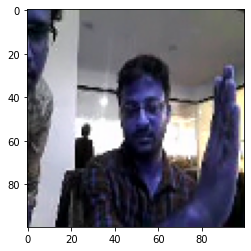

In [163]:
origImage = imageList[0].copy()
print(origImage)
print(origImage.shape)
#for channel in [0,1,2]:
#  origImage[:,:,channel] = (origImage[:,:,channel] - origImage[:,:,channel].mean() )/(np.percentile(origImage[:,:,channel],95)-np.percentile(origImage[:,:,channel],5))
#origImage = normalizeImage(origImage,"norm")
resizeImage = origImage.copy()
#resizeImage = np.resize(resizeImage, (119,159,3))

#print(resizeImage.shape)
#print(resizeImage)
resizeImage = cv2.resize(origImage, (100, 100), interpolation = cv2.INTER_CUBIC)


plt.imshow(resizeImage)

  

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,30)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)/batch_size;
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[batch*batch_size + folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[batch*batch_size + folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   # channelImage = image[:, : , 0]
                   # batch_data[folder,idx,:,:,0] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                   # channelImage = image[:, : , 1]
                   # batch_data[folder,idx,:,:,1] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                  #channelImage = image[:, : , 2]
                   # batch_data[folder,idx,:,:,2] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            remainingImageCount = len(folder_list)% batch_size
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[batch*batch_size + folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[batch*batch_size + folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    PIXEL =100
                    INPUT_IMAGE_SIZE = (PIXEL, PIXEL)
                    image.resize(INPUT_IMAGE_SIZE)

                    channelImage = image[:, : , 0]
                    #ToDo : check using standard deviation normalization too 
                    batch_data[folder,idx,:,:,0] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                    channelImage = image[:, : , 1]
                    batch_data[folder,idx,:,:,1] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                    channelImage = image[:, : , 2]
                    batch_data[folder,idx,:,:,2] = channelImage - np.percentile(channelImage,5)/ np.percentile(channelImage,95) - np.percentile(channelImage,5)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) 

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [3]:
optimiser = #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

SyntaxError: ignored

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)